## Resources
Kaggle: https://www.kaggle.com/datasets/itsnahm/data-house

## Imports

In [1]:
# data processing libraries
import pandas as pd
import numpy as np

import pickle
import os

# plot libraries
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# remove warning for clean notebook
import warnings
warnings.filterwarnings("ignore")

# Sklean libraries for data modelling
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso

from sklearn.tree import DecisionTreeRegressor

## Functions

In [2]:
# remove all outliers
def remove_outliers(df):
    
    # remove decimals on bathroom attribute
    df['bathrooms'] = df['bathrooms'].apply(np.floor)
    
    # remove property without bathrooms | some properties might not have bathrooms so this decision will be based on dicussion with the project manager
    # df = df[df['bathrooms'] != 0]
    
    # remove property without bedrooms 
    df = df[df['bedrooms'] != 0]
    
    # keep properties with number bathrooms less than equal to number of bedrooms
    df = df[df['bathrooms'] <= df['bedrooms']]

    # price per lot outliers removal 
    # only keep dataset where price per lot is between mean + 3 * standard deviation
    ppl_mean = df['price_per_lot'].mean()
    ppl_std = df['price_per_lot'].std()
    df = df[((ppl_mean - 3 * ppl_std) < df['price_per_lot']) & (df['price_per_lot'] < (ppl_mean + 3 * ppl_std))]
    
    return df

In [3]:
def find_best_model(X, y, split, test_size, rand_state):
    algorithms = {'linear_regression' : {'model' : LinearRegression(),
                                         'params' : {}},
                  
                  'lasso': {'model': Lasso(),
                            'params': {'alpha': [1,2],
                                       'selection': ['random', 'cyclic']}},
                  
                  'decision_tree': {'model': DecisionTreeRegressor(),
                                    'params': {'criterion' : ['squared_error','friedman_mse'],
                                               'splitter': ['best','random']}}}
                    
    scores = []
    cv = ShuffleSplit(n_splits = split, test_size = test_size, random_state = rand_state)
    
    for algo_name, config in algorithms.items():
        
        gs =  GridSearchCV(config['model'], config['params'], cv = cv, return_train_score=False)
        gs.fit(X, y)
        
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': str(gs.best_params_)
        })

    return pd.DataFrame(scores, columns = ['model','best_score','best_params'])

## Data Exploration

### Data Extraction

In [4]:
# extract data from csv to dataframe
df_csv = pd.read_csv('dataset/data_house.csv')

# check the data from csv
df_csv

,Unnamed: 0,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,...,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509
21609,21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,...,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200
21610,21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,...,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007
21611,21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,...,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287


In [5]:
# unique locations/zipcode which will be used for feature engineering 
df_csv['zipcode'].value_counts()

98103    602
98038    590
98115    583
98052    574
98117    553
        ... 
98102    105
98010    100
98024     81
98148     57
98039     50
Name: zipcode, Length: 70, dtype: int64

In [6]:
df_csv.columns

Index(['Unnamed: 0', 'id', 'date', 'price', 'bedrooms', 'bathrooms',
       'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition',
       'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated',
       'zipcode', 'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

### Data Transformation

In [7]:
df_main = df_csv[['zipcode', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade', 
                  'sqft_lot', 'sqft_above', 'sqft_living', 'sqft_basement', 'price']]

In [8]:
df_main

,zipcode,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_lot,sqft_above,sqft_living,sqft_basement,price
0,98178,3,1.00,1.0,0,0,3,7,5650,1180,1180,0,221900.0
1,98125,3,2.25,2.0,0,0,3,7,7242,2170,2570,400,538000.0
2,98028,2,1.00,1.0,0,0,3,6,10000,770,770,0,180000.0
3,98136,4,3.00,1.0,0,0,5,7,5000,1050,1960,910,604000.0
4,98074,3,2.00,1.0,0,0,3,8,8080,1680,1680,0,510000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,98103,3,2.50,3.0,0,0,3,8,1131,1530,1530,0,360000.0
21609,98146,4,2.50,2.0,0,0,3,8,5813,2310,2310,0,400000.0
21610,98144,2,0.75,2.0,0,0,3,7,1350,1020,1020,0,402101.0
21611,98027,3,2.50,2.0,0,0,3,8,2388,1600,1600,0,400000.0


In [9]:
df_main['price_per_lot'] = df_main['price']/df_main['sqft_lot']

In [10]:
df_main.columns

Index(['zipcode', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'view',
       'condition', 'grade', 'sqft_lot', 'sqft_above', 'sqft_living',
       'sqft_basement', 'price', 'price_per_lot'],
      dtype='object')

In [11]:
df_main.describe()

,zipcode,bedrooms,bathrooms,floors,waterfront,view,condition,grade,sqft_lot,sqft_above,sqft_living,sqft_basement,price,price_per_lot
count,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000
mean,98077.939805,3.370842,2.114757,1.494309,0.007542,0.234303,3.409430,7.656873,1.510697e+04,1788.390691,2079.899736,291.509045,5.400881e+05,88.966710
std,53.505026,0.930062,0.770163,0.539989,0.086517,0.766318,0.650743,1.175459,4.142051e+04,828.090978,918.440897,442.575043,3.671272e+05,94.055247
min,98001.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,5.200000e+02,290.000000,290.000000,0.000000,7.500000e+04,0.163119
25%,98033.000000,3.000000,1.750000,1.000000,0.000000,0.000000,3.000000,7.000000,5.040000e+03,1190.000000,1427.000000,0.000000,3.219500e+05,33.333333
50%,98065.000000,3.000000,2.250000,1.500000,0.000000,0.000000,3.000000,7.000000,7.618000e+03,1560.000000,1910.000000,0.000000,4.500000e+05,59.223301
75%,98118.000000,4.000000,2.500000,2.000000,0.000000,0.000000,4.000000,8.000000,1.068800e+04,2210.000000,2550.000000,560.000000,6.450000e+05,107.594937
max,98199.000000,33.000000,8.000000,3.500000,1.000000,4.000000,5.000000,13.000000,1.651359e+06,9410.000000,13540.000000,4820.000000,7.700000e+06,2027.208539


### Data Visualization on Price againts other attributes

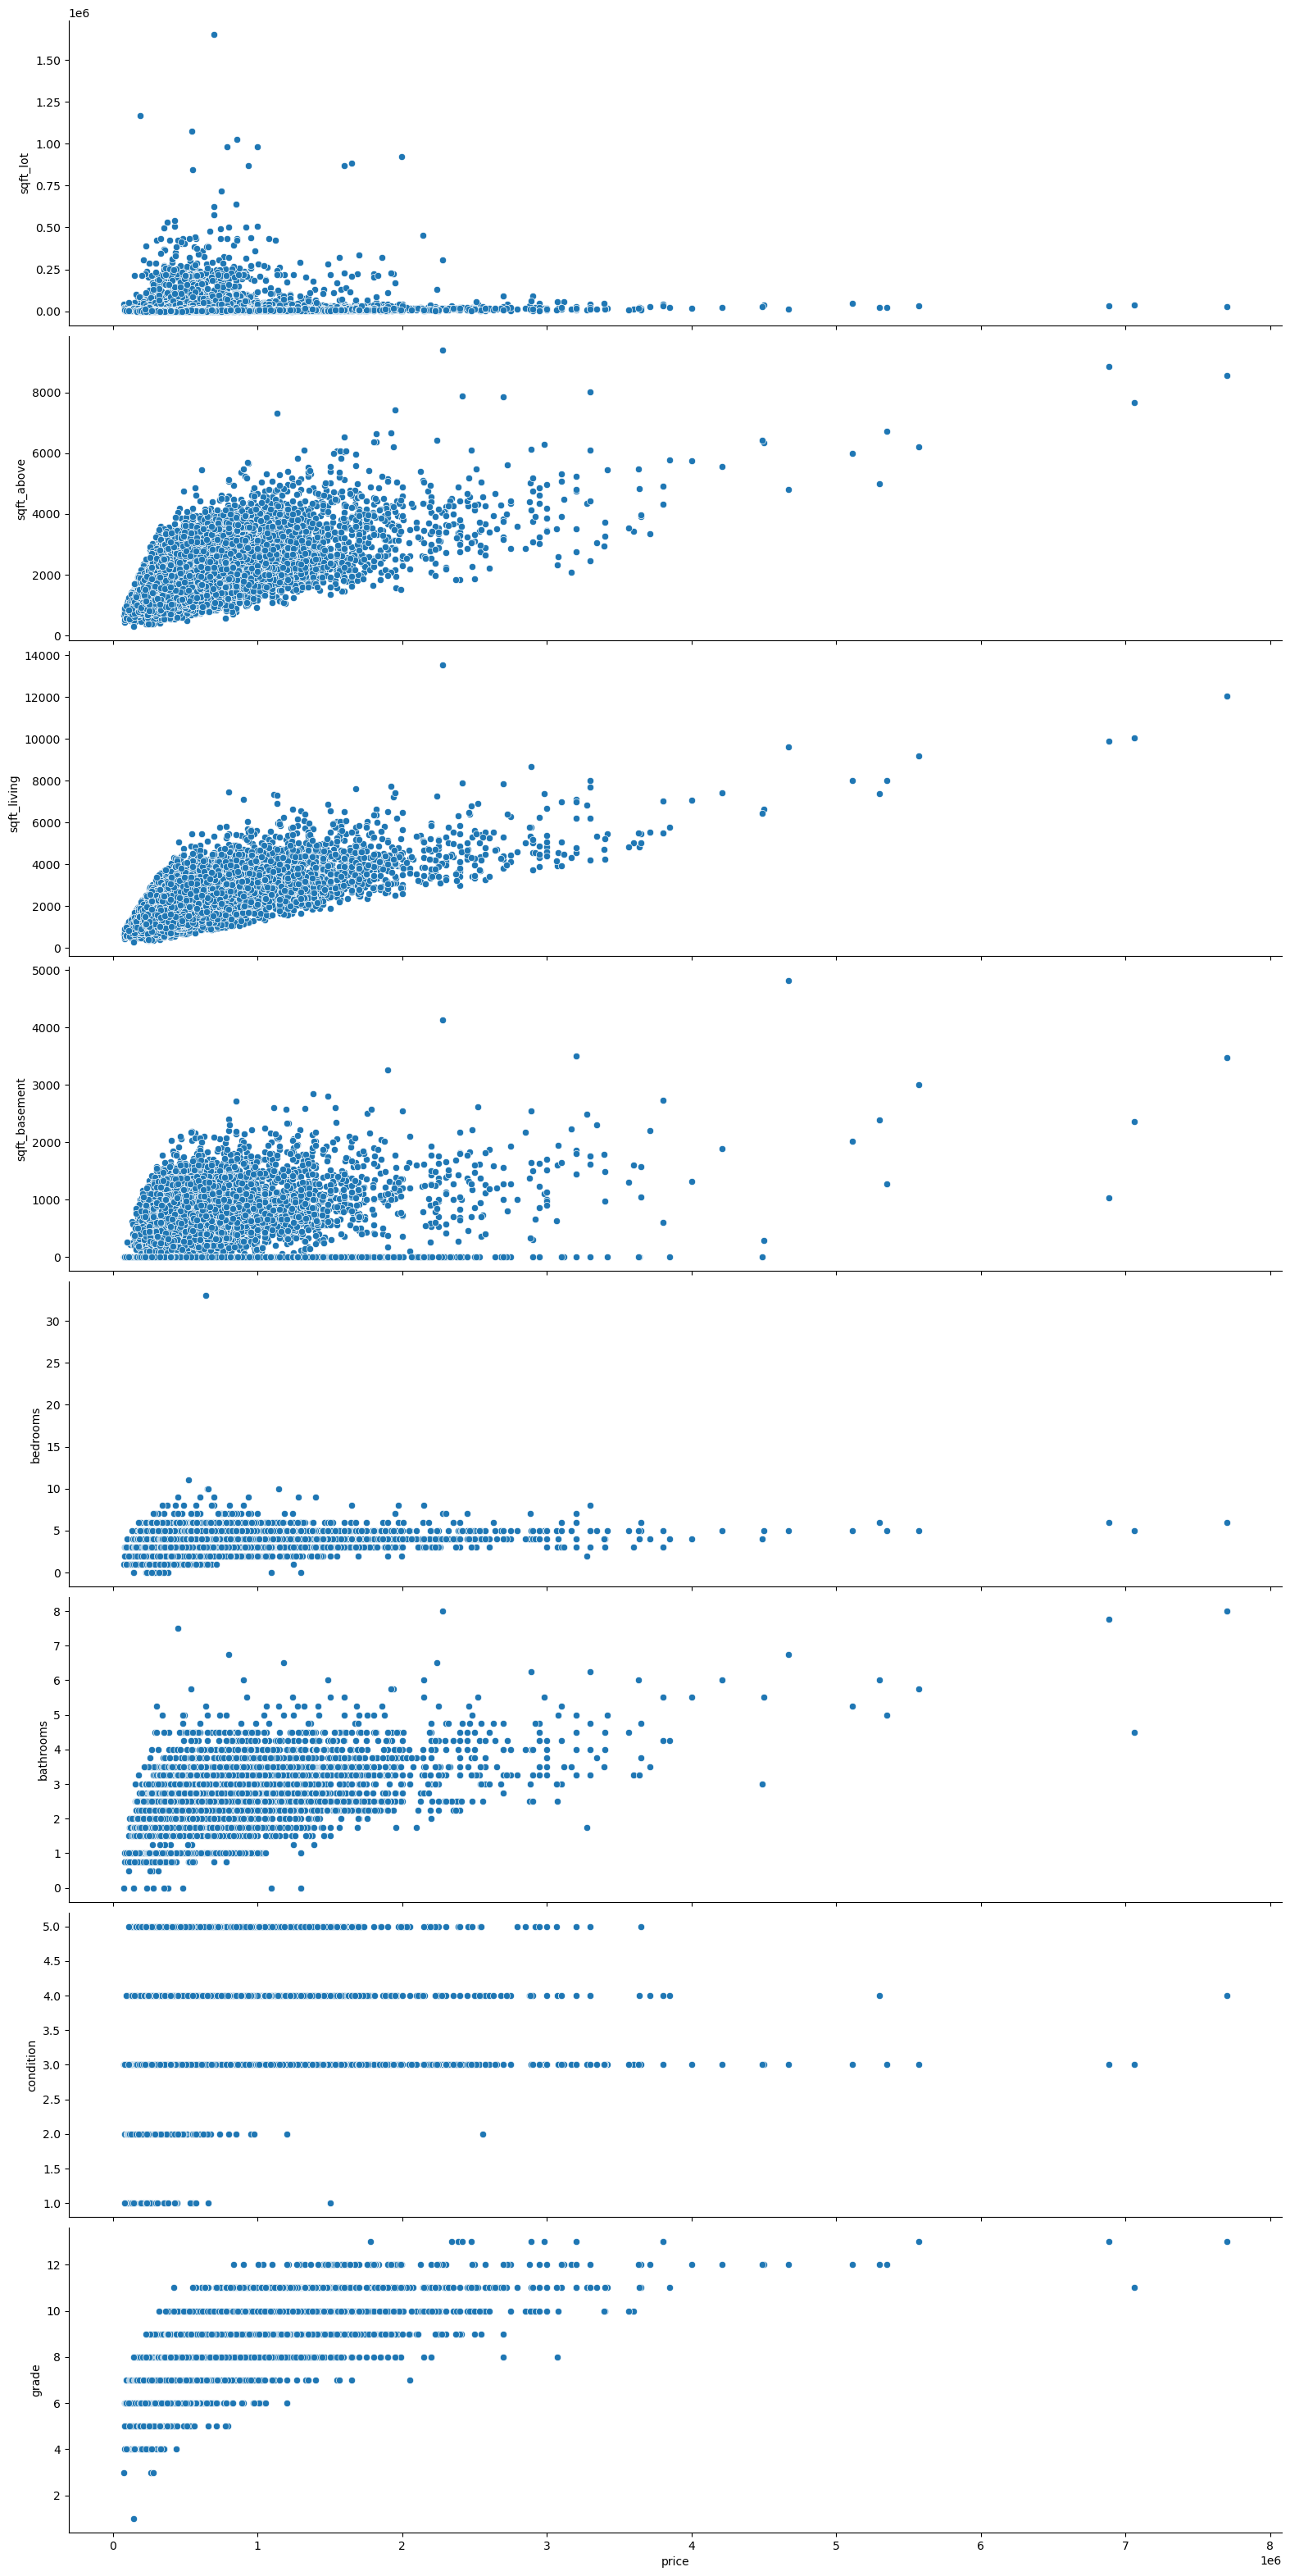

In [12]:
# Plot of price against all columns
sns.pairplot(df_main, x_vars = ['price'], y_vars = ['sqft_lot', 'sqft_above', 'sqft_living', 'sqft_basement', 'bedrooms', 'bathrooms', 'condition', 'grade'], height = 4, aspect = 4)

### Data clean up

#### Null Values

In [13]:
# check if there are any null values
df_main.isna().sum()

zipcode          0
bedrooms         0
bathrooms        0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_lot         0
sqft_above       0
sqft_living      0
sqft_basement    0
price            0
price_per_lot    0
dtype: int64

#### Outliers removal

In [14]:
# remove outliers
df_main = remove_outliers(df_main)

### Adding Dummies Columns

In [15]:
# create dummies columns
dummies = pd.get_dummies(df_main.zipcode)

# append dummie columns to main df
df_final = pd.concat([df_main.drop('zipcode', axis = 'columns'), dummies.drop(98178, axis = 1)], axis = 'columns')

## Data Modelling

### X and y preparation

In [16]:
split = 5
test_size = 0.2
rand_state = 10

# split X and y
X = df_main.drop('price', axis = 'columns')
y = df_main.price

# scale X
scale = StandardScaler()
X_scaled = scale.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = test_size, random_state = 10)

### Model training

In [17]:
best_model = find_best_model(X_scaled, y, split, test_size, rand_state)

#### Find best model for the dataset

In [18]:
# read best model into csv file and combine with the new result
if os.path.exists('best_model.csv'): 
    prev_model = pd.read_csv('best_model.csv')
    prev_model = prev_model[['model','best_score','best_params']]
    
    best_model = pd.concat([prev_model, best_model], axis = 0, ignore_index = True)
    best_model.drop_duplicates(inplace = True)

# write best model into csv
best_model.to_csv('best_model.csv', columns = ['model','best_score','best_params'])

In [19]:
best_model

,model,best_score,best_params
0,linear_regression,0.700104,{}
1,lasso,0.700067,"{'alpha': 2, 'selection': 'random'}"
2,decision_tree,0.925281,"{'criterion': 'friedman_mse', 'splitter': 'best'}"


##### Test best model

In [20]:
model_dtree = DecisionTreeRegressor(criterion = 'friedman_mse', splitter = 'best')
model_dtree.fit(X_train, y_train)
model_dtree.score(X_train, y_train)

1.0

##### Save the tuned model into pickle file

In [21]:
with open('home_prices_decs_tree.pickle', 'wb') as f:
    pickle.dump(model_dtree, f)